Попробуем научить модель распознавать покемонов. Импортируем библиотеки и настраиваем гиперпараметры:

In [4]:
import matplotlib.pyplot as plt
import torch
from torch import nn
import numpy as np
import torchvision as tv
import pandas as pd
import seaborn as sns
import os
from sklearn.metrics import confusion_matrix
from skimage import io
from pandas import read_csv
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
from PIL import Image
from sklearn.model_selection import KFold
from torchvision import transforms as T
batch_size=64
csv_path = "C:\\Users\\Professional\\Pictures\\pokemon_pictures.csv"
root_dir = "C:\\Users\\Professional\\Pictures\\PokemonData_resized"

[Датасет](https://www.kaggle.com/datasets/lantian773030/pokemonclassification) включает 7000 изображений покемонов. Его сначала пришлось отформатировать, чтобы его принял pytorch, код для этой цели в пуллреквесте с неудачной генерацией.

In [ ]:
#вот такая штука
class pokemon_dataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.annotations = read_csv(csv_file)
        #print(self.annotations)
        self.root_dir = root_dir
        self.transform = transform 
        self.annotations.iloc[:, 1] = self.annotations.iloc[:, 1].astype(int)
    def __len__(self):
        return len(self.annotations)
    def __getitem__(self, index):
        img_path = os.path.join(self.root_dir, self.annotations.iloc[index, 0])
        image = io.imread(img_path)
        y_label = torch.tensor(self.annotations.iloc[index, 1])
        if self.transform:
            image = self.transform(image)
        return(image, y_label)
dataset=pokemon_dataset("C:\\Users\\Professional\\Pictures\\pokemon_pictures.csv","C:\\Users\\Professional\\Pictures\\PokemonData_resized",T.ToTensor() )

Следующие несколько ячеек закомментированы, так как разделение на train и test проводится в цикле кросс-валидации.

In [ ]:
"""
trainset, testset = torch.utils.data.random_split(dataset, [5336,1500])
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
for inputs, labels in trainloader:
    inputs, labels = inputs.to("cuda"), labels.to("cuda")
"""

'\ntrainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)\nfor inputs, labels in trainloader:\n    inputs, labels = inputs.to("cuda"), labels.to("cuda")\n'

In [7]:
"""
train = torch.utils.data.DataLoader(trainset, batch_size=batch_size)
test = torch.utils.data.DataLoader(testset, batch_size=batch_size)
"""

'\ntrain = torch.utils.data.DataLoader(trainset, batch_size=batch_size)\ntest = torch.utils.data.DataLoader(testset, batch_size=batch_size)\n'

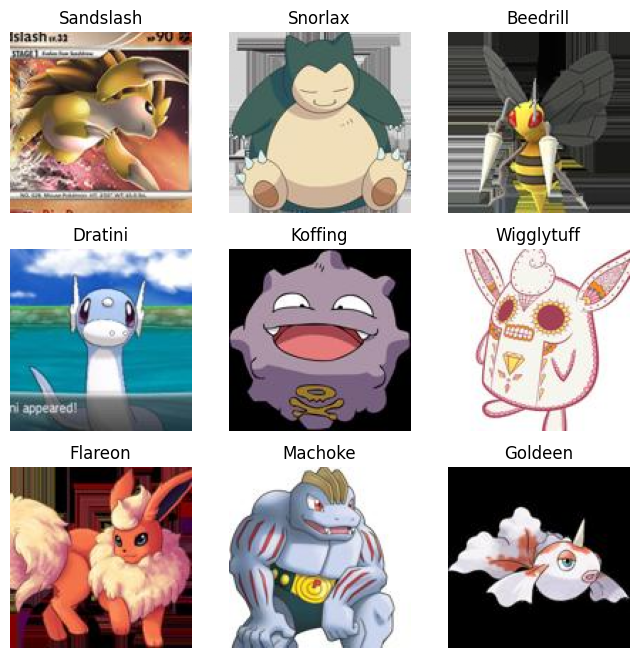

In [8]:
labels = pd.read_csv("C:\\Users\\Professional\\Pictures\\pokemon_list.csv",header=None).values.tolist()
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(dataset), size=(1,)).item()
    img, label = dataset[sample_idx]
    img = img.swapaxes(0,1)
    img = img.swapaxes(1,2)
    figure.add_subplot(rows, cols, i)
    plt.title(labels[int(label.item())][0])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

Модель используем +/- прямо из лекции:

In [9]:

def evaluate_accuracy(data_iter, net, dev):
    acc_sum, n = torch.Tensor([0]).to(dev), 0
    for X, y in data_iter:
        X, y = X.to(dev), y.to(dev)
        acc_sum += (net(X).argmax(axis=1) == y).sum()
        n += y.shape[0]
    return acc_sum.item() / n

def train_model(net, train_iter, test_iter, trainer, num_epochs, dev):
    loss = nn.CrossEntropyLoss(reduction='sum')
    for epoch in range(num_epochs):
        train_l_sum, train_acc_sum, n = 0.0, 0.0, 0
        net.train()
        for X, y in train_iter:
            trainer.zero_grad()
            X, y = X.to(dev), y.to(dev, dtype=torch.long)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            trainer.step()
            train_l_sum += l.item()
            train_acc_sum += (y_hat.argmax(axis=1) == y).sum().item()
            n += y.shape[0]
        test_acc = evaluate_accuracy(test_iter, net, dev)
        print('epoch %d, loss %.4f, train acc %.3f, test acc %.3f'
              % (epoch + 1, train_l_sum / n, train_acc_sum / n, test_acc))

In [10]:

model = nn.Sequential(
    nn.Conv2d(3, 64, kernel_size=3, padding=2),
    nn.MaxPool2d(3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(64, 64, kernel_size=5, padding=2),
    nn.MaxPool2d(3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(64, 128, kernel_size=3, padding=2),
    nn.MaxPool2d(2, stride=2, padding=1),
    nn.ReLU(),
    nn.Flatten(),
    nn.BatchNorm1d(41472),
    nn.Linear(41472, 512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, 1024),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(1024, 150),
).to("cuda")
model = model.float()
lr, num_epochs = 0.0003, 15
trainer = torch.optim.Adam(model.parameters(), lr=lr)


Для нормальной точности нужна кросс-валидация. Пусть будет 10 раундов по 15 эпох:

In [11]:
kfold = KFold(n_splits=10, shuffle=True)

# Start print
print('--------------------------------')

  # K-fold Cross Validation model evaluation
for fold, (train_ids, test_ids) in enumerate(kfold.split(dataset)):
    
    # Print
    print(f'FOLD {fold}')
    print('--------------------------------')
    
    # Sample elements randomly from a given list of ids, no replacement.
    train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
    test_subsampler = torch.utils.data.SubsetRandomSampler(test_ids)
    
    # Define data loaders for training and testing data in this fold
    trainloader = torch.utils.data.DataLoader(
                      dataset, 
                      batch_size=10, sampler=train_subsampler)
    for inputs, labels in trainloader:
      inputs, labels = inputs.to("cuda"), labels.to("cuda")
    testloader = torch.utils.data.DataLoader(
                      dataset,
                      batch_size=10, sampler=test_subsampler)
    for inputs, labels in testloader:
      inputs, labels = inputs.to("cuda"), labels.to("cuda")
    
    
    %time train_model(model, trainloader, testloader, trainer, num_epochs, "cuda")

--------------------------------
FOLD 0
--------------------------------
epoch 1, loss 4.8373, train acc 0.025, test acc 0.056
epoch 2, loss 3.8999, train acc 0.105, test acc 0.167
epoch 3, loss 3.1869, train acc 0.223, test acc 0.230
epoch 4, loss 2.7113, train acc 0.321, test acc 0.294
epoch 5, loss 2.2243, train acc 0.423, test acc 0.335
epoch 6, loss 1.9575, train acc 0.476, test acc 0.351
epoch 7, loss 1.6612, train acc 0.549, test acc 0.370
epoch 8, loss 1.4394, train acc 0.602, test acc 0.386
epoch 9, loss 1.2999, train acc 0.642, test acc 0.386
epoch 10, loss 1.1266, train acc 0.682, test acc 0.406
epoch 11, loss 0.9824, train acc 0.722, test acc 0.409
epoch 12, loss 0.9273, train acc 0.728, test acc 0.389
epoch 13, loss 0.8284, train acc 0.757, test acc 0.418
epoch 14, loss 0.7504, train acc 0.774, test acc 0.439
epoch 15, loss 0.6616, train acc 0.799, test acc 0.405
CPU times: total: 33min 28s
Wall time: 8min 37s
FOLD 1
--------------------------------
epoch 1, loss 0.9141, t

Пожалуй, 150 эпох в сумме оказалось многовато. Можно было сделать, например, 5 по 10. Сохраним модель:

In [13]:
torch.save(model, 'model.pth')

In [12]:
#%time train_model(model, train, test, trainer, num_epochs, "cuda")